In [3]:
# ============================================================
# BLOCO 0) SETUP + CARREGA MODELO BASE N2
# ============================================================

!pip -q install PuLP

import pandas as pd
import numpy as np
import pulp as pl
import matplotlib.pyplot as plt

# carrega tudo do seu modelo N2
# (sets, parâmetros, build_model, etc.)
%run n5.py

print("Base N2 carregada.")
print("Fazendas:", F)
print("Grãos:", G)


Modelo estruturado com sucesso.
Nº variáveis: 292, Nº restrições: 236
Modelo estruturado com sucesso.
→ Variáveis: 292 | Restrições: 236

🔄 Resolvendo com CBC...

✅ Status: Optimal
💰 Lucro total: R$ 30,189,579.03

🌾 ÁREA PLANTADA (ha) POR FAZENDA E GRÃO

Fazenda Maruim:
  - Aveia     :   300.00 ha

Fazenda Gaucha:
  - Milho     :   400.00 ha

Fazenda CamposGerais:
  - Trigo     :   481.67 ha
  - Aveia     :    18.33 ha

Fazenda Pantanal:
  - Milho     :   951.39 ha
  - Soja      :   248.61 ha

Fazenda Cerrado:
  - Sorgo     :    13.22 ha
  - Girassol  :  2486.78 ha

Fazenda Capital:
  - Milho     :    20.00 ha
  - Soja      :   997.52 ha
  - Sorgo     :   436.12 ha
  - Girassol  :   746.36 ha

🚜 PRODUÇÃO (t) POR FAZENDA E GRÃO

Fazenda Maruim:
  - Aveia     :    1110.00 t

Fazenda Gaucha:
  - Milho     :    2400.00 t

Fazenda CamposGerais:
  - Trigo     :    2890.00 t
  - Aveia     :     102.67 t

Fazenda Pantanal:
  - Milho     :    8220.00 t
  - Soja      :    1379.79 t

Fazenda Cerr

In [4]:
# ============================================================
# BLOCO 1) PRODUTIVIDADES N3 (POR ANO) + DF
# ============================================================

prod = {
    "Maruim_SC": {
        "Aveia":     [2.211, 2.245, 2.155, 2.098],
        "Girassol":  [0.363, 0.369, 0.354, 0.344],
        "Milho":     [2.774, 2.816, 2.704, 2.632],
        "Soja":      [1.435, 1.457, 1.399, 1.362],
        "Sorgo":     [0.551, 0.560, 0.537, 0.523],
        "Trigo":     [2.367, 2.403, 2.306, 2.245]
    },

    "Gaucha_RS": {
        "Aveia":     [2.126, 2.149, 2.122, 2.169],
        "Milho":     [3.596, 3.635, 3.590, 3.670],
        "Soja":      [1.853, 1.873, 1.849, 1.891],
        "Trigo":     [2.278, 2.302, 2.273, 2.324]
    },

    "CamposGerais_PR": {
        "Aveia":     [3.115, 3.224, 3.177, 3.188],
        "Girassol":  [0.338, 0.350, 0.345, 0.346],
        "Milho":     [0.959, 0.993, 0.978, 0.982],
        "Soja":      [0.527, 0.545, 0.537, 0.539],
        "Sorgo":     [0.513, 0.531, 0.523, 0.525],
        "Trigo":     [3.337, 3.454, 3.404, 3.416]
    },

    "Pantanal_MS": {
        "Girassol":  [1.213, 1.236, 1.256, 1.240],
        "Milho":     [5.706, 5.814, 5.909, 5.834],
        "Soja":      [3.173, 3.233, 3.286, 3.245],
        "Sorgo":     [2.453, 2.500, 2.540, 2.508]
    },

    "Cerrado_MT": {
        "Aveia":     [0.483, 0.500, 0.464, 0.466],
        "Girassol":  [0.972, 1.006, 0.933, 0.937],
        "Milho":     [3.174, 3.284, 3.046, 3.061],
        "Soja":      [1.846, 1.910, 1.771, 1.780],
        "Sorgo":     [1.965, 2.033, 1.886, 1.895],
        "Trigo":     [0.517, 0.535, 0.496, 0.498]
    },

    "Capital_GO": {
        "Aveia":     [0.564, 0.545, 0.534, 0.571],
        "Girassol":  [1.133, 1.095, 1.074, 1.148],
        "Milho":     [3.700, 3.576, 3.507, 3.751],
        "Soja":      [2.152, 2.079, 2.040, 2.181],
        "Sorgo":     [2.291, 2.214, 2.171, 2.322],
        "Trigo":     [0.603, 0.582, 0.571, 0.611]
    }
}

rows = []
for fazenda, graos in prod.items():
    for grao, valores in graos.items():
        for ano, v in enumerate(valores, start=1):
            rows.append([fazenda, grao, ano, v])

df_prod = pd.DataFrame(rows, columns=["Fazenda", "Grao", "Ano", "Prod_Esperada"])
df_prod.head()


,Fazenda,Grao,Ano,Prod_Esperada
0,Maruim_SC,Aveia,1,2.211
1,Maruim_SC,Aveia,2,2.245
2,Maruim_SC,Aveia,3,2.155
3,Maruim_SC,Aveia,4,2.098
4,Maruim_SC,Girassol,1,0.363


In [5]:
# ============================================================
# BLOCO 2) MAPA DE NOMES + PADJ POR ANO
# ============================================================

# no N2 os nomes são curtos
FAZENDA_MAP = {
    "Maruim_SC": "Maruim",
    "Gaucha_RS": "Gaucha",
    "CamposGerais_PR": "CamposGerais",
    "Pantanal_MS": "Pantanal",
    "Cerrado_MT": "Cerrado",
    "Capital_GO": "Capital"
}

def build_padj_from_prod(prod_dict, ano_idx):
    """
    Retorna dict Padj[(f,g)] para um ano específico (ano_idx=1..4),
    preenchendo 0.0 para combinações não existentes.
    """
    padj_ano = {}
    # start com tudo 0
    for f in F:
        for g in G:
            padj_ano[(f, g)] = 0.0

    # preenche com valores novos
    for fazenda_long, graos in prod_dict.items():
        f = FAZENDA_MAP[fazenda_long]
        for g, serie in graos.items():
            padj_ano[(f, g)] = float(serie[ano_idx - 1])
    return padj_ano


In [6]:
# ============================================================
# BLOCO 3) RUNNER DE 1 ANO (TROCA PADJ, RESOLVE, SALVA SAÍDAS)
# ============================================================

def solve_one_year(ano_idx, solver_msg=False):
    """
    1) atualiza Padj global
    2) build_model() do N2
    3) resolve
    4) retorna dicionário com dfs de output
    """

    # 1) atualiza Padj (global do n5.py)
    Padj.clear()
    Padj.update(build_padj_from_prod(prod, ano_idx))

    # 2) monta modelo
    model, V = build_model()

    # 3) resolve
    status = model.solve(pl.PULP_CBC_CMD(msg=solver_msg))

    lucro = pl.value(model.objective)
    status_str = pl.LpStatus[status]

    x, prod_var, q, buyQty, sellQty = V["x"], V["prod"], V["q"], V["buyQty"], V["sellQty"]

    # --- área plantada ---
    area_rows = []
    for f in F:
        for g in G:
            val = x[f][g].value()
            if val is None: val = 0.0
            area_rows.append([ano_idx, f, g, val])
    df_area = pd.DataFrame(area_rows, columns=["Ano", "Fazenda", "Grao", "Area_ha"])

    # --- produção por grão ---
    prod_rows = []
    for f in F:
        for g in G:
            val = prod_var[f][g].value()
            if val is None: val = 0.0
            prod_rows.append([ano_idx, f, g, val])
    df_prod_ano = pd.DataFrame(prod_rows, columns=["Ano", "Fazenda", "Grao", "Producao_t"])

    # --- rações ---
    racao_rows = []
    for l in L:
        for p in P_of_L[l]:
            val = q[(l, p)].value()
            if val is None: val = 0.0
            racao_rows.append([ano_idx, l, p, val])
    df_racao = pd.DataFrame(racao_rows, columns=["Ano", "Linha", "Pack", "Qtd_itens"])

    # --- compras / vendas de ingredientes ---
    buy_rows, sell_rows = [], []
    for i in I:
        vb = buyQty[i].value() or 0.0
        vs = sellQty[i].value() or 0.0
        buy_rows.append([ano_idx, i, vb])
        sell_rows.append([ano_idx, i, vs])

    df_buy  = pd.DataFrame(buy_rows,  columns=["Ano", "Ingrediente", "Compra_t"])
    df_sell = pd.DataFrame(sell_rows, columns=["Ano", "Ingrediente", "Venda_t"])

    return {
        "ano": ano_idx,
        "status": status_str,
        "lucro": lucro,
        "df_area": df_area,
        "df_prod": df_prod_ano,
        "df_racao": df_racao,
        "df_buy": df_buy,
        "df_sell": df_sell
    }


In [7]:
# ============================================================
# BLOCO 4) RODA 4 ANOS + COMPARA TUDO
# ============================================================

results = []
for ano in [1, 2, 3, 4]:
    out = solve_one_year(ano_idx=ano, solver_msg=False)
    results.append(out)
    print(f"Ano {ano} | Status={out['status']} | Lucro=R$ {out['lucro']:,.2f}")

df_area_all  = pd.concat([r["df_area"]  for r in results], ignore_index=True)
df_prod_all  = pd.concat([r["df_prod"]  for r in results], ignore_index=True)
df_racao_all = pd.concat([r["df_racao"] for r in results], ignore_index=True)

# lucro por ano
df_lucro = pd.DataFrame(
    [[r["ano"], r["lucro"]] for r in results],
    columns=["Ano", "Lucro_R$"]
)

df_lucro


Ano 1 | Status=Optimal | Lucro=R$ 20,493,424.53
Ano 2 | Status=Optimal | Lucro=R$ 20,674,029.70
Ano 3 | Status=Optimal | Lucro=R$ 20,449,252.97
Ano 4 | Status=Optimal | Lucro=R$ 20,557,585.78


,Ano,Lucro_R$
0,1,2.049342e+07
1,2,2.067403e+07
2,3,2.044925e+07
3,4,2.055759e+07


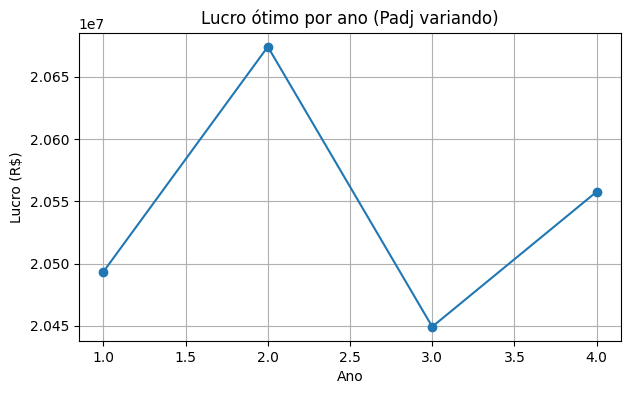

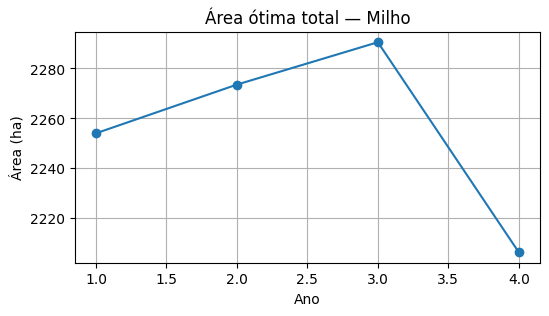

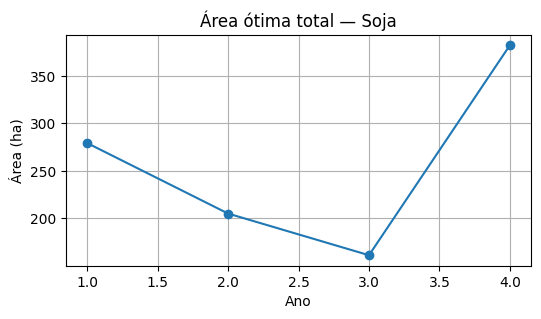

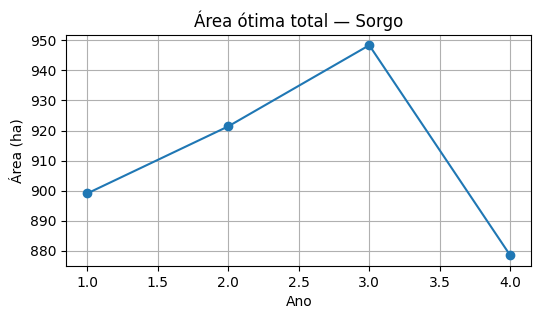

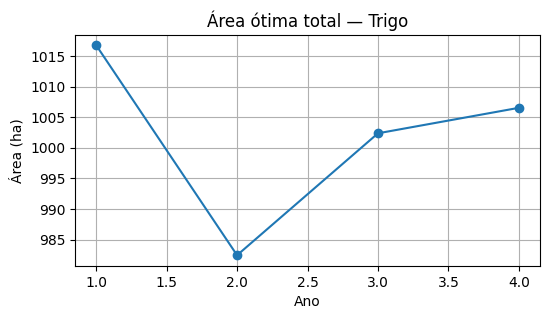

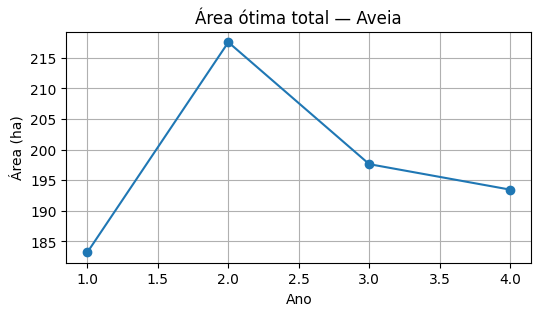

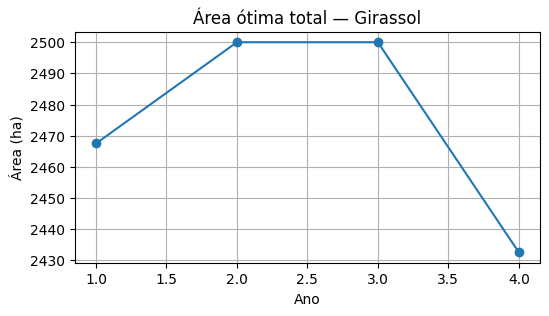

,Ano,Linha,Pack,Qtd_itens
5,1,BC-G,std,150000.0
7,1,BL-L,std,110000.0
3,1,AV-P,std,105000.0
1,1,AQ-T,std,60000.0
8,1,EQ-M,std,60000.0
10,1,OV-M,std,60000.0
11,1,PA-PET,std,50000.0
4,1,BC-G,bb,3000.0
6,1,BL-L,bb,2200.0
0,1,AQ-T,bb,1499.0


,Ano,Linha,Pack,Qtd_itens
17,2,BC-G,std,150000.0
19,2,BL-L,std,110000.0
15,2,AV-P,std,105000.0
13,2,AQ-T,std,60000.0
20,2,EQ-M,std,60000.0
22,2,OV-M,std,60000.0
23,2,PA-PET,std,50000.0
16,2,BC-G,bb,3000.0
18,2,BL-L,bb,2200.0
12,2,AQ-T,bb,1470.0


,Ano,Linha,Pack,Qtd_itens
29,3,BC-G,std,150000.0
31,3,BL-L,std,110000.0
27,3,AV-P,std,105000.0
25,3,AQ-T,std,60000.0
32,3,EQ-M,std,60000.0
34,3,OV-M,std,60000.0
35,3,PA-PET,std,50000.0
28,3,BC-G,bb,3000.0
30,3,BL-L,bb,2200.0
24,3,AQ-T,bb,1489.0


,Ano,Linha,Pack,Qtd_itens
41,4,BC-G,std,150000.0
43,4,BL-L,std,110000.0
39,4,AV-P,std,105000.0
37,4,AQ-T,std,60000.0
44,4,EQ-M,std,60000.0
46,4,OV-M,std,60000.0
47,4,PA-PET,std,50000.0
40,4,BC-G,bb,3000.0
42,4,BL-L,bb,2200.0
36,4,AQ-T,bb,1470.0


In [8]:
# ============================================================
# BLOCO 5) GRAFICOS PRA SLIDE
# ============================================================

# 1) Lucro por ano
plt.figure(figsize=(7,4))
plt.plot(df_lucro["Ano"], df_lucro["Lucro_R$"], marker="o")
plt.title("Lucro ótimo por ano (Padj variando)")
plt.xlabel("Ano")
plt.ylabel("Lucro (R$)")
plt.grid(True)
plt.show()

# 2) Área total por grão (somando fazendas)
df_area_gr = df_area_all.groupby(["Ano","Grao"], as_index=False)["Area_ha"].sum()

for g in G:
    sub = df_area_gr[df_area_gr["Grao"] == g]
    plt.figure(figsize=(6,3))
    plt.plot(sub["Ano"], sub["Area_ha"], marker="o")
    plt.title(f"Área ótima total — {g}")
    plt.xlabel("Ano")
    plt.ylabel("Área (ha)")
    plt.grid(True)
    plt.show()

# 3) Top rações por ano
df_racao_all["Qtd_itens"] = df_racao_all["Qtd_itens"].astype(float)

top_racao = (
    df_racao_all.groupby(["Ano","Linha","Pack"], as_index=False)["Qtd_itens"].sum()
    .sort_values(["Ano","Qtd_itens"], ascending=[True, False])
)

for ano in [1,2,3,4]:
    display(top_racao[top_racao["Ano"]==ano].head(10))


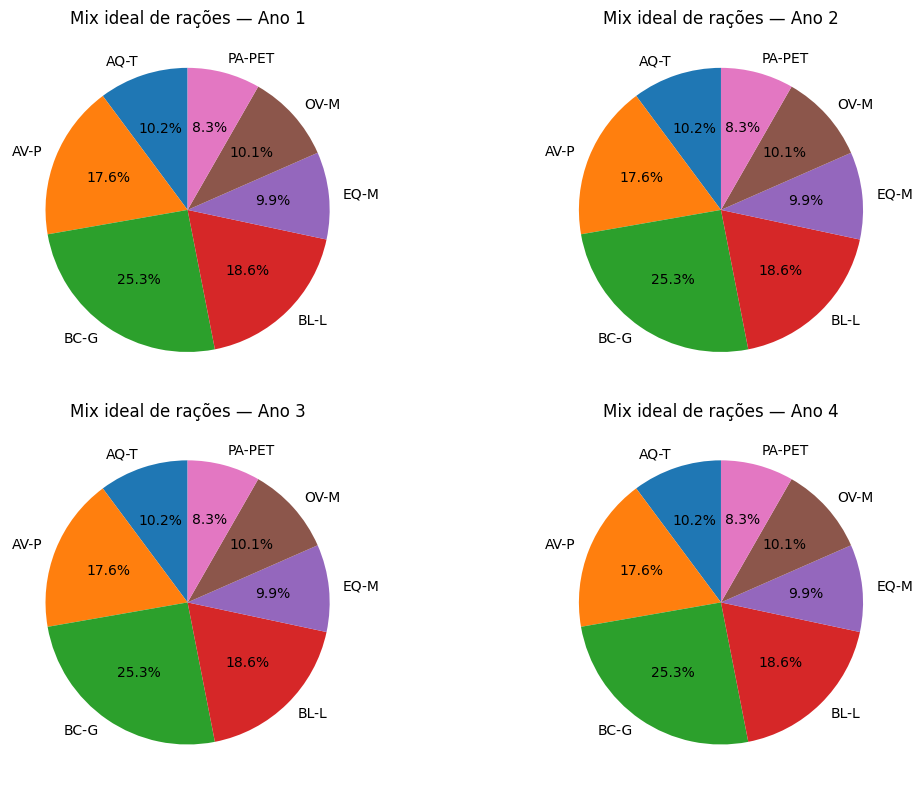

In [9]:
# ============================================================
# PIZZA POR ANO — mix ideal de rações
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_pizzas_racao_por_ano(df_racao_all,
                             ano_col="Ano",
                             tipo_col="Linha",
                             qtd_col="Qtd_itens",
                             titulo_base="Mix ideal de rações"):
    """
    Gera 4 gráficos de pizza (Ano 1..4) mostrando share (%) por tipo de ração.
    Usa df_racao_all do teu LP.
    """

    d = df_racao_all.copy()
    d[qtd_col] = d[qtd_col].astype(float)

    anos = sorted(d[ano_col].unique())
    n = len(anos)

    # layout 2x2 (se tiver 4 anos)
    nrows = int(np.ceil(n/2))
    ncols = 2 if n > 1 else 1

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 8))
    axes = np.array(axes).reshape(-1)

    for i, ano in enumerate(anos):
        ax = axes[i]
        sub = d[d[ano_col] == ano]

        # soma por tipo (Linha) = tipo de ração
        agg = sub.groupby(tipo_col, as_index=False)[qtd_col].sum()

        # remove zeros p/ não poluir a pizza
        agg = agg[agg[qtd_col] > 1e-9]

        labels = agg[tipo_col].tolist()
        values = agg[qtd_col].tolist()

        ax.pie(
            values,
            labels=labels,
            autopct=lambda p: f"{p:.1f}%" if p >= 3 else "",  # só mostra % se >=3%
            startangle=90
        )
        ax.set_title(f"{titulo_base} — Ano {ano}")

    # desliga eixos sobrando (se n != 4)
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


# --- roda ---
plot_pizzas_racao_por_ano(df_racao_all)


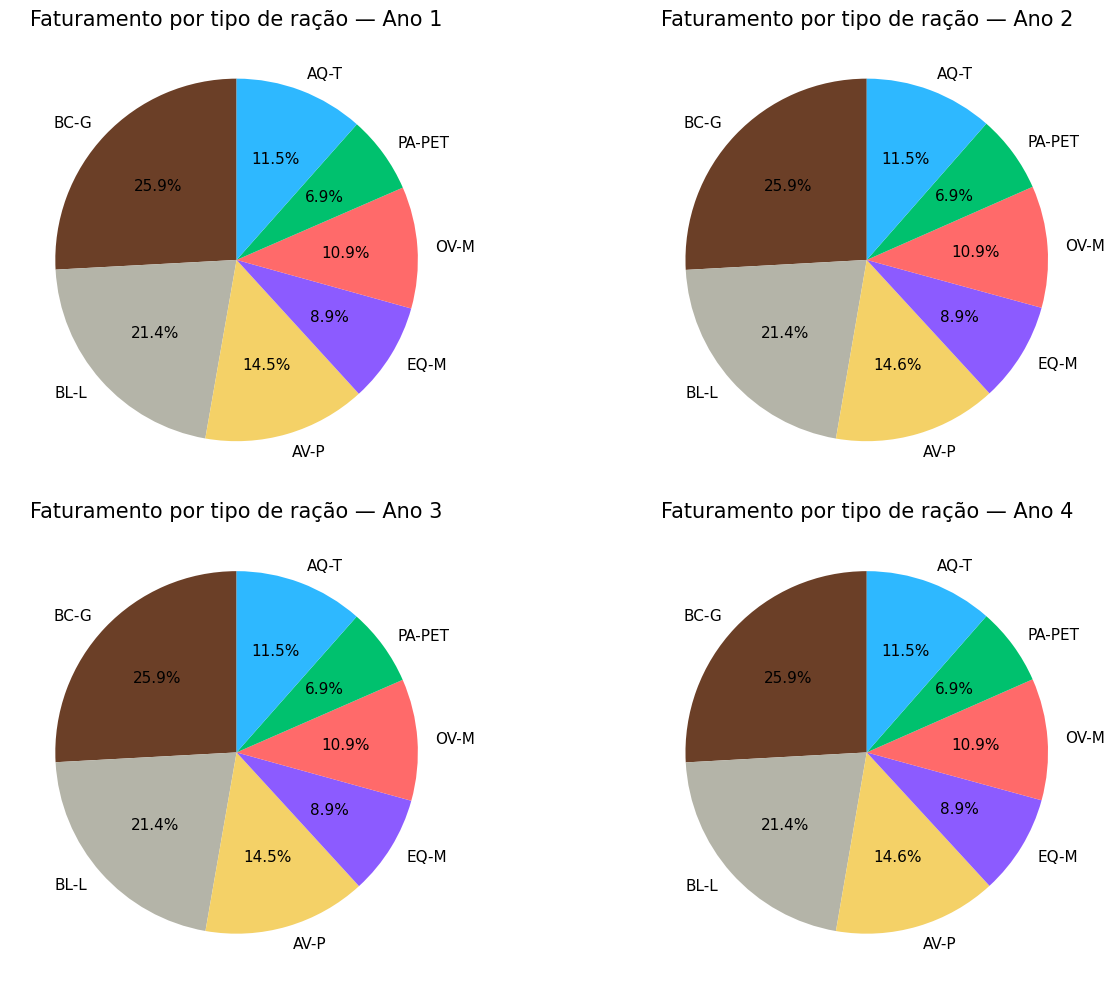

In [10]:
# ============================================================
# PIZZA DE FATURAMENTO POR TIPO DE RAÇÃO — 4 ANOS
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

# Paleta consistente (mesma ordem SEMPRE)
CORES_LINHAS = {
    "BC-G":   "#6b3f27",  # Bovino Corte (marrom)
    "BL-L":   "#b4b4a8",  # Bovino Leite (cinza claro)
    "AV-P":   "#f4d167",  # Galinha (amarelo)
    "EQ-M":   "#8c5bff",  # Cavalo (roxo)
    "OV-M":   "#ff6a6a",  # Ovelha (vermelho)
    "PA-PET": "#00c16e",  # Pássaro (verde)
    "AQ-T":   "#2eb8ff",  # Tilápia (azul)
}

def plot_faturamento_pizza(df_racao_all, price, titulo_base="Faturamento por tipo de ração"):
    """
    df_racao_all: dataframe com colunas [Ano, Linha, Pack, Qtd_itens]
    price: dict price[(l,p)] do modelo MILP
    """

    # garantir tipo numérico
    df = df_racao_all.copy()
    df["Qtd_itens"] = df["Qtd_itens"].astype(float)

    anos = sorted(df["Ano"].unique())
    n = len(anos)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # para 4 anos
    axes = axes.flatten()

    for idx, ano in enumerate(anos):
        ax = axes[idx]
        sub = df[df["Ano"] == ano]

        # Faturamento por linha
        fatur_linha = {}
        for l in L:
            total = 0
            for p in P_of_L[l]:
                mask = (sub["Linha"] == l) & (sub["Pack"] == p)
                qnt = sub.loc[mask, "Qtd_itens"].sum()
                total += qnt * price[(l,p)]
            fatur_linha[l] = total

        # remover linhas zeradas
        fatur_linha = {l:v for l,v in fatur_linha.items() if v > 1e-9}

        labels = list(fatur_linha.keys())
        values = list(fatur_linha.values())
        cores = [CORES_LINHAS[l] for l in labels]

        ax.pie(
            values,
            labels=[f"{l}" for l in labels],
            autopct=lambda p: f"{p:.1f}%" if p >= 3 else "",
            startangle=90,
            colors=cores,
            textprops={'fontsize': 11}
        )
        ax.set_title(f"{titulo_base} — Ano {ano}", fontsize=15)

    # desliga axes extras caso não tenha 4 anos
    for j in range(idx+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


# --- roda ---
plot_faturamento_pizza(df_racao_all, price)
